In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold

Minimizando a Resolução da imagem e deginindo o tamanho do Lote

In [2]:
base_dir = "./training"

IMAGE_WIDTH  = 256
IMAGE_HEIGHT = 256
BATCH_SIZE = 32

Definindo diretório para checkpoints

In [3]:
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Criando um gerador de dados que irá redimensionar as imagens e usa 20% dos dados para validação.

In [4]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1. / 255,
  horizontal_flip=True,
  fill_mode='nearest',
  zoom_range=0.3,
  width_shift_range=0.3,
  height_shift_range=0.3,
  rotation_range=30,
  validation_split=0.2)

Definindo a dimensão das imagens para acomodar imagens RGB (com 3 canais)

In [10]:
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

Criando uma model com base na CNN pré treinada MobileNet V2, desenvolvida pela Google e pré-treinada usando o dataset da ImageNet, sem a camada superior, que inclui as camadas de classificação.

In [11]:
base_model = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)


2023-11-20 15:01:16.356037: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-20 15:01:16.356068: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-20 15:01:16.356076: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-20 15:01:16.356151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-20 15:01:16.356345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Aplicando fine-tunning nas últimas camadas do modelo, forçando os pesos a se ajustarem äs características mais específicas do dataset.

In [12]:
base_model.trainable = True

Mostrando a quantidade de camadas no modelo.

In [13]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  707


Montando o modelo da CNN:
1. Modelo pré-treinado da MobileNet V2 com fine-tunning a partir da 100a camada;
2. Camada de Convolução com 32 filtros e ativação Relu;
3. Camada de Dropout de 20% dos nós;
4. Camada de Pooling;
5. Camada FC com 17 labels de classificação

In [14]:
model = tf.keras.Sequential([
    base_model,  # 1
    tf.keras.layers.GlobalAveragePooling2D(),  # 4
    tf.keras.layers.Dense(50, activation='softmax')  # 5
])

Compilando a model

In [15]:
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001, momentum=0.9),  # 1
              loss='categorical_crossentropy',  # 2
              metrics=['accuracy'])  # 3
# To see the model summary in a tabular structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 50)                96050     
                                                                 
Total params: 18418034 (70.26 MB)
Trainable params: 18188978 (69.39 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________


Utilizando Stratified 10-fold Cross-validation para validação do modelo

In [16]:
n_folds = 10
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

Carregando nomes dos arquivos de imagem e seus respectivos rótulos

In [17]:
filenames = []
labels    = []

for classname in os.listdir(base_dir):
  class_dir = os.path.join(base_dir, classname)
  if os.path.isdir(class_dir):
    for filename in os.listdir(class_dir):
      if filename.lower().endswith(".jpg"):
        labels.append(classname)
        filenames.append(os.path.join(class_dir, filename))

filenames = np.array(filenames)
labels    = np.array(labels)

Definindo as épocas para o treinamento da model

In [18]:
epochs = 2

Aplicando o Stratified 10-fold Cross-Validation

In [19]:
history_list = []

for fold, (train_index, val_index) in enumerate(stratified_kfold.split(filenames, labels)):
  print(f"Fold {fold + 1}/{n_folds}")

  # Separando os dados de treinamento e validação
  train_filenames = filenames[train_index]
  val_filenames = filenames[val_index]

  train_labels = labels[train_index]
  val_labels = labels[val_index]

  # Criando geradores de dados de treinamento e validação
  train_generator = data_generator.flow_from_dataframe(
    pd.DataFrame({"filename": train_filenames, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
  )

  val_generator = data_generator.flow_from_dataframe(
    pd.DataFrame({"filename": val_filenames, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
  )

  # Treinando o modelo
  history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)
  history_list.append(history.history)

Fold 1/10
Found 10035 validated image filenames belonging to 50 classes.
Found 1115 validated image filenames belonging to 50 classes.
Epoch 1/2


2023-11-20 15:01:25.609630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


314/314 [==============================] - ETA: 0s - loss: 3.4594 - accuracy: 0.2145

2023-11-20 15:16:06.490811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


314/314 [==============================] - 920s 3s/step - loss: 3.4594 - accuracy: 0.2145 - val_loss: 2.6607 - val_accuracy: 0.4502
Epoch 2/2
314/314 [==============================] - 1012s 3s/step - loss: 2.1556 - accuracy: 0.5810 - val_loss: 1.5671 - val_accuracy: 0.6700
Fold 2/10
Found 10035 validated image filenames belonging to 50 classes.
Found 1115 validated image filenames belonging to 50 classes.
Epoch 1/2
314/314 [==============================] - 1017s 3s/step - loss: 1.3975 - accuracy: 0.7469 - val_loss: 1.0427 - val_accuracy: 0.8179
Epoch 2/2
314/314 [==============================] - 1013s 3s/step - loss: 0.9734 - accuracy: 0.8455 - val_loss: 0.7414 - val_accuracy: 0.8709
Fold 3/10
Found 10035 validated image filenames belonging to 50 classes.
Found 1115 validated image filenames belonging to 50 classes.
Epoch 1/2
314/314 [==============================] - 1008s 3s/step - loss: 0.7196 - accuracy: 0.8844 - val_loss: 0.5315 - val_accuracy: 0.9202
Epoch 2/2
314/314 [=======

Mostrando as métricas em um gráfico

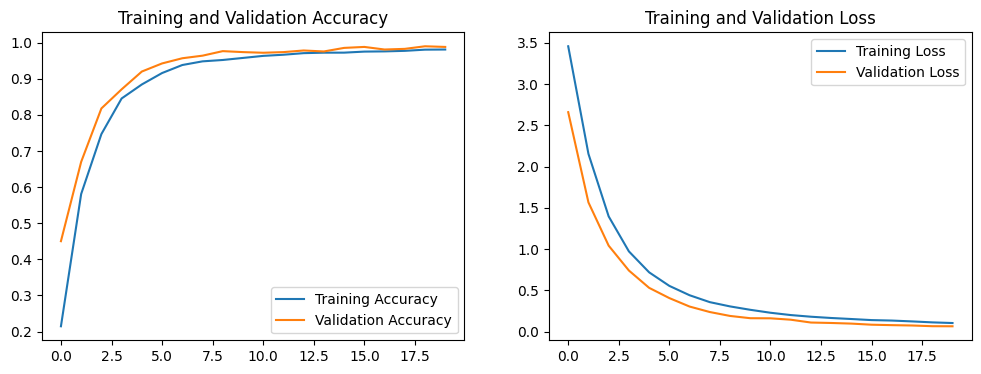

In [24]:
acc_values      = [acc for fold in history_list for acc in fold['accuracy']]
val_acc_values  = [acc for fold in history_list for acc in fold['val_accuracy']]
loss_values     = [acc for fold in history_list for acc in fold['loss']]
val_loss_values = [acc for fold in history_list for acc in fold['val_loss']]

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()